# Step 8 - Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
sns.set() # Setting seaborn as default style even if use only matplotlib
pd.set_option('display.max_rows', None)

In [2]:
def target_rel(df, feature, feature_title):
    
    import matplotlib.pyplot as plt
    # import matplotlib.transforms as mtrans

    fig, axes = plt.subplots(1,2, sharex=False, figsize=(10,5))
    fig.suptitle(f'Arrival Delay by {feature_title}')

    sns.barplot(ax=axes[0], data=df, x=feature, y='arr_delay')
    # axes[0].set_title(f'{feature_title} Barplot')
    sns.stripplot(ax=axes[1], data=df,x=feature, y='arr_delay')
    # axes[1].set_title(f'{feature_title} Stripplot')

In [3]:
# get the cleaned dataset

import pickle

with open(r'..\data\flight_data.pickle','rb') as flight_data_file:
     df_flights = pickle.load(flight_data_file)

In [4]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_time,arr_delay,cancelled,diverted,dup,crs_elapsed_time,actual_elapsed_time,air_time,flights,distance
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,9.0,19.0,0,0,N,140,124.0,112.0,1,986
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,241.0,46.0,0,0,N,150,161.0,142.0,1,1099
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,1111.0,-9.0,0,0,N,150,145.0,132.0,1,1099
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,827.0,-3.0,0,0,N,55,50.0,34.0,1,197
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,1912.0,37.0,0,0,N,55,51.0,34.0,1,197


In [5]:
df_test_features = pd.read_csv(r'..\csvs\test_features.csv', sep=',')
df_test_features.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,origin_city_name,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance
0,1577865600000,WN,WN,WN,5888,WN,N951WN,5888,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1810,1945,N,95,1,363
1,1577865600000,WN,WN,WN,6276,WN,N467WN,6276,13891,ONT,"Ontario, CA",14771,SFO,"San Francisco, CA",1150,1320,N,90,1,363
2,1577865600000,WN,WN,WN,4598,WN,N7885A,4598,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",2020,2130,N,70,1,333
3,1577865600000,WN,WN,WN,4761,WN,N551WN,4761,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",1340,1455,N,75,1,333
4,1577865600000,WN,WN,WN,5162,WN,N968WN,5162,13891,ONT,"Ontario, CA",14831,SJC,"San Jose, CA",915,1035,N,80,1,333


In [6]:
## what is going on with fl_date in the test set? Do we need to address that?

In [7]:
test_feat = list(df_test_features.columns)
test_feat

['fl_date',
 'mkt_unique_carrier',
 'branded_code_share',
 'mkt_carrier',
 'mkt_carrier_fl_num',
 'op_unique_carrier',
 'tail_num',
 'op_carrier_fl_num',
 'origin_airport_id',
 'origin',
 'origin_city_name',
 'dest_airport_id',
 'dest',
 'dest_city_name',
 'crs_dep_time',
 'crs_arr_time',
 'dup',
 'crs_elapsed_time',
 'flights',
 'distance']

In [8]:
df_flights = pd.concat([df_flights[test_feat], df_flights['arr_delay']],axis=1)
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,dest_airport_id,dest,dest_city_name,crs_dep_time,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,13851,OKC,"Oklahoma City, OK",1930,2350,N,140,1,986,19.0
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,13871,OMA,"Omaha, NE",2125,155,N,150,1,1099,46.0
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,13871,OMA,"Omaha, NE",650,1120,N,150,1,1099,-9.0
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,13891,ONT,"Ontario, CA",735,830,N,55,1,197,-3.0
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,13891,ONT,"Ontario, CA",1740,1835,N,55,1,197,37.0


### Mean/Median Monthly Arrival Delay and Arr_Delay

In [9]:
df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])
df_flights['year'] = df_flights['fl_date'].dt.year
df_flights['month'] = df_flights['fl_date'].dt.month
df_flights['day'] = df_flights['fl_date'].dt.day

In [10]:
## look at correlation between month and arr_delay

mean_arr_delay = df_flights.groupby('month', as_index=False).agg(mean_arr_delay = ('arr_delay','mean')).sort_values(by='mean_arr_delay', ascending=False)
mean_arr_delay.set_index('month',inplace=True)
mean_arr_delay = mean_arr_delay.T
mean_arr_delay

month,8,6,7,5,2,12,4,3,10,1,11,9
mean_arr_delay,10.135397,10.120094,8.901098,6.805443,6.587885,6.06855,5.382526,2.893273,2.466155,2.297154,2.229622,0.508462


In [11]:
month_dict = mean_arr_delay.to_dict('records')

In [12]:
month_dict

[{8: 10.135397157651207,
  6: 10.120094007050529,
  7: 8.901097631426921,
  5: 6.805443276744812,
  2: 6.5878846686997505,
  12: 6.068549859978083,
  4: 5.3825262618498595,
  3: 2.8932732468674436,
  10: 2.46615507960142,
  1: 2.2971539456662353,
  11: 2.2296219216094344,
  9: 0.5084617327607982}]

In [13]:
df_flights['mean_arr_delay'] = df_flights['month'].map(month_dict[0])

In [14]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_arr_time,dup,crs_elapsed_time,flights,distance,arr_delay,year,month,day,mean_arr_delay
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,2350,N,140,1,986,19.0,2018,1,1,2.297154
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,155,N,150,1,1099,46.0,2018,1,1,2.297154
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,1120,N,150,1,1099,-9.0,2018,1,1,2.297154
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,830,N,55,1,197,-3.0,2018,1,1,2.297154
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,1835,N,55,1,197,37.0,2018,1,1,2.297154


In [15]:
df_flights['arr_delay'].corr(df_flights['mean_arr_delay'])

0.0658661713996643

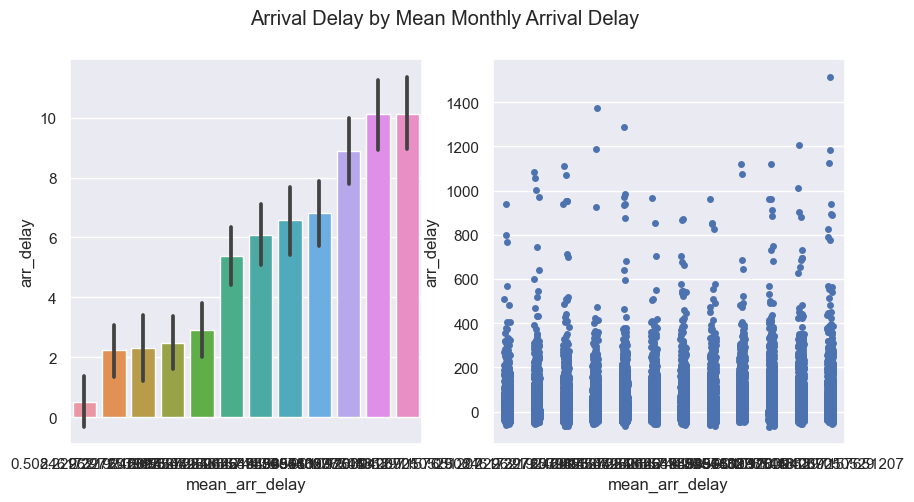

In [16]:
target_rel(df_flights, feature='mean_arr_delay', feature_title='Mean Monthly Arrival Delay')

In [17]:
# get median monthly arrival delay

median_arr_delay = df_flights.groupby('month', as_index=False).agg(median_arr_delay = ('arr_delay','median')).sort_values(by='median_arr_delay', ascending=False)
median_arr_delay.set_index('month',inplace=True)
median_arr_delay = median_arr_delay.T
median_arr_delay

month,5,6,7,8,12,2,4,11,3,10,1,9
median_arr_delay,-5.0,-5.0,-5.0,-5.0,-5.0,-6.0,-6.0,-6.0,-7.0,-7.0,-8.0,-8.0


In [18]:
month_dict = median_arr_delay.to_dict('records')

In [19]:
df_flights['median_arr_delay'] = df_flights['month'].map(month_dict[0])
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,dup,crs_elapsed_time,flights,distance,arr_delay,year,month,day,mean_arr_delay,median_arr_delay
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,N,140,1,986,19.0,2018,1,1,2.297154,-8.0
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,N,150,1,1099,46.0,2018,1,1,2.297154,-8.0
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,N,150,1,1099,-9.0,2018,1,1,2.297154,-8.0
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,N,55,1,197,-3.0,2018,1,1,2.297154,-8.0
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,N,55,1,197,37.0,2018,1,1,2.297154,-8.0


In [20]:
df_flights['arr_delay'].corr(df_flights['median_arr_delay'])

0.05691698369021277

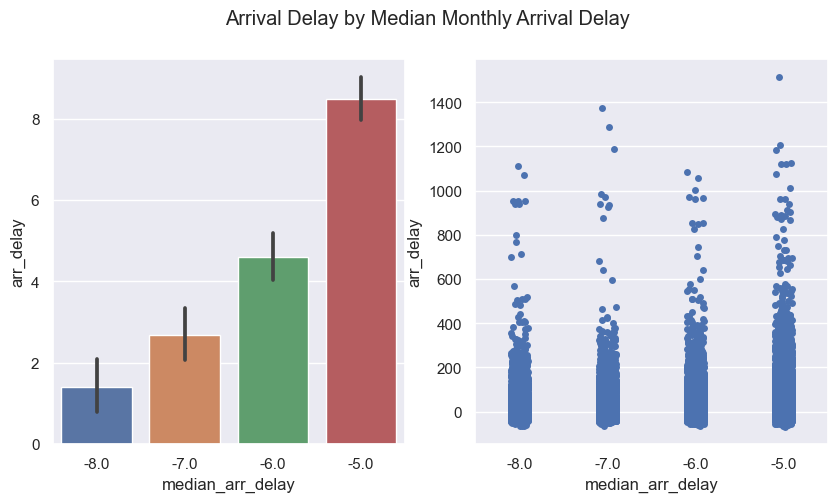

In [21]:
target_rel(df_flights, feature='median_arr_delay', feature_title='Median Monthly Arrival Delay')

### Season and Arr_Delay

In [22]:
## look at relationship between season and arr_delay

season_dict = {
    1:'Winter',
    2:'Winter',
    3:'Spring',
    4:'Spring',
    5:'Spring',
    6:'Summer',
    7:'Summer',
    8:'Summer',
    9:'Fall',
    10:'Fall',
    11:'Fall',
    12:'Winter'}
df_flights["season"] = df_flights["month"].map(season_dict)


In [23]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,crs_elapsed_time,flights,distance,arr_delay,year,month,day,mean_arr_delay,median_arr_delay,season
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,140,1,986,19.0,2018,1,1,2.297154,-8.0,Winter
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,150,1,1099,46.0,2018,1,1,2.297154,-8.0,Winter
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,150,1,1099,-9.0,2018,1,1,2.297154,-8.0,Winter
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,55,1,197,-3.0,2018,1,1,2.297154,-8.0,Winter
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,55,1,197,37.0,2018,1,1,2.297154,-8.0,Winter


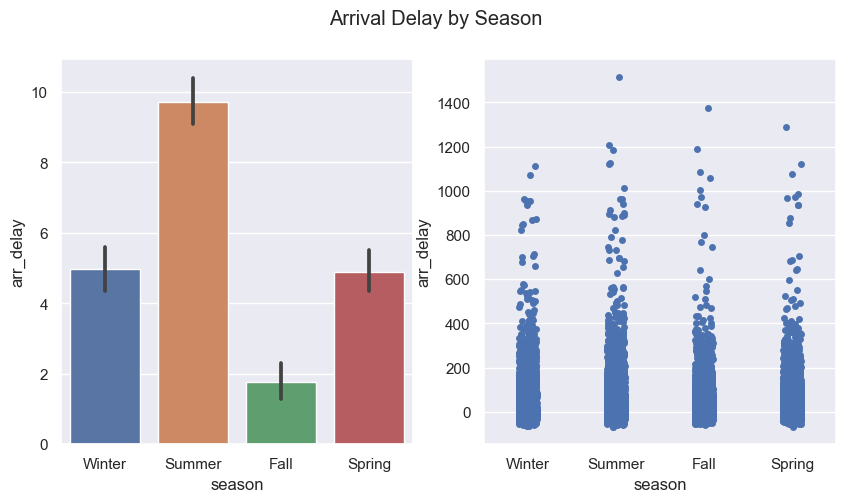

In [24]:
target_rel(df_flights, feature='season', feature_title='Season')

### Day of Week and Arr_Delay

In [25]:
# see if there's a relationship between day of week and arr_delay

# df_flights['fl_date'] = pd.to_datetime(df_flights['fl_date'])

In [26]:
df_flights['day_of_week'] = df_flights['fl_date'].dt.day_name()

In [27]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,flights,distance,arr_delay,year,month,day,mean_arr_delay,median_arr_delay,season,day_of_week
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,1,986,19.0,2018,1,1,2.297154,-8.0,Winter,Monday
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,1,1099,46.0,2018,1,1,2.297154,-8.0,Winter,Monday
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,1,1099,-9.0,2018,1,1,2.297154,-8.0,Winter,Monday
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,1,197,-3.0,2018,1,1,2.297154,-8.0,Winter,Monday
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,1,197,37.0,2018,1,1,2.297154,-8.0,Winter,Monday


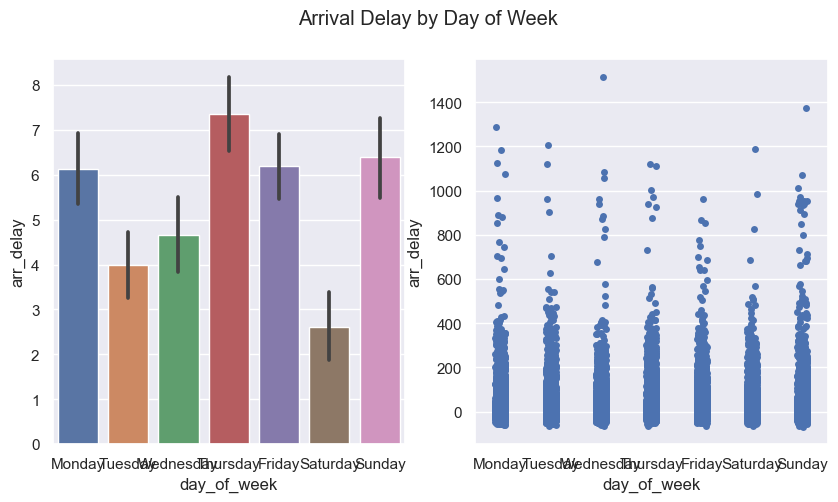

In [28]:
target_rel(df_flights, feature='day_of_week', feature_title='Day of Week')

### Weekday/Weekend and Arr_Delay

In [29]:
df_flights["is_weekend"] = df_flights['fl_date'].dt.dayofweek > 4

In [30]:
df_flights[['day_of_week','is_weekend']].groupby(['day_of_week','is_weekend']).count()

,
day_of_week,is_weekend
Friday,False
Monday,False
Saturday,True
Sunday,True
Thursday,False
Tuesday,False
Wednesday,False


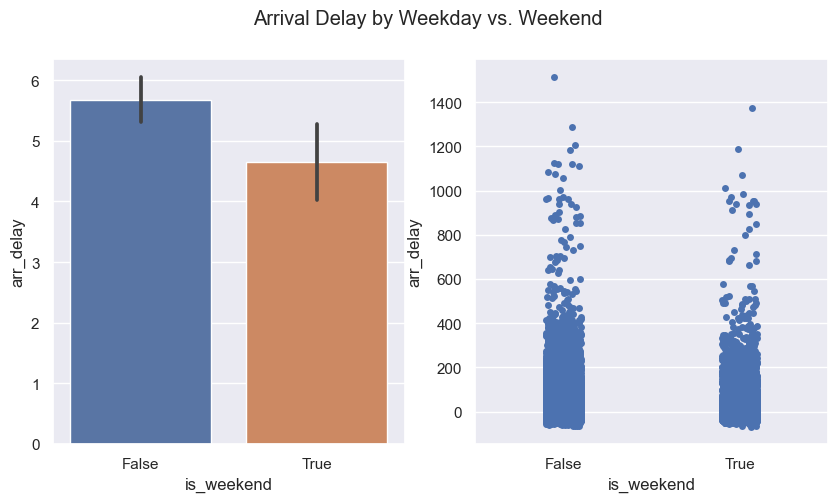

In [31]:
target_rel(df_flights, feature='is_weekend', feature_title='Weekday vs. Weekend')

### Holidays and Arr_Delay

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

dr = pd.date_range(start='2018-01-01', end='2019-12-31')

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

df_flights['is_holiday'] = df_flights['fl_date'].isin(holidays)
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,arr_delay,year,month,day,mean_arr_delay,median_arr_delay,season,day_of_week,is_weekend,is_holiday
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,19.0,2018,1,1,2.297154,-8.0,Winter,Monday,False,True
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,46.0,2018,1,1,2.297154,-8.0,Winter,Monday,False,True
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,-9.0,2018,1,1,2.297154,-8.0,Winter,Monday,False,True
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,-3.0,2018,1,1,2.297154,-8.0,Winter,Monday,False,True
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,37.0,2018,1,1,2.297154,-8.0,Winter,Monday,False,True


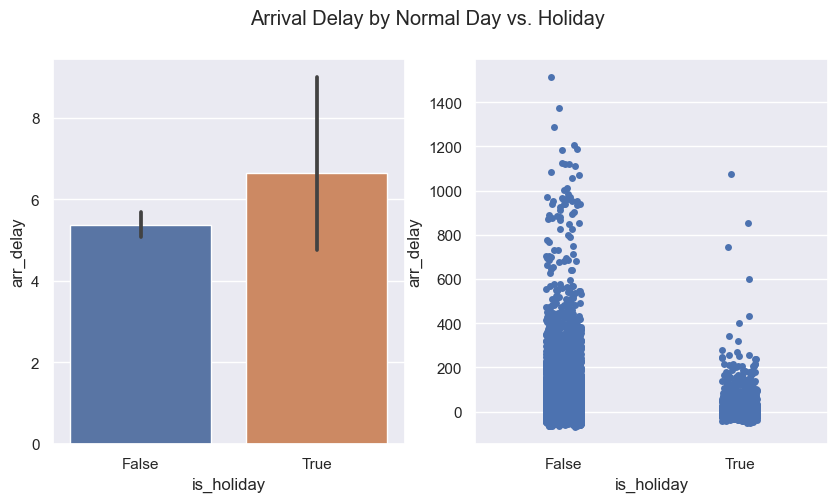

In [33]:
target_rel(df_flights, feature='is_holiday', feature_title='Normal Day vs. Holiday')

### Departure Time of Day and Arr_Delay

In [34]:
# look at relationship between departure time of day and arr_delay

df_flights['crs_dep_time'] = df_flights['crs_dep_time'].astype(int)

In [35]:
df_flights['crs_dep_time'] = pd.to_datetime(df_flights['crs_dep_time'], format = '%H%M', errors = 'coerce')
df_flights['crs_dep_time_hour'] = df_flights['crs_dep_time'].dt.hour

In [36]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights['crs_dep_time_of_day'] = pd.cut(df_flights['crs_dep_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [37]:
df_flights.head(20)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,month,day,mean_arr_delay,median_arr_delay,season,day_of_week,is_weekend,is_holiday,crs_dep_time_hour,crs_dep_time_of_day
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,19.0,late afternoon
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,21.0,evening
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,6.0,late morning
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,7.0,late morning
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,17.0,late afternoon
5,2018-01-01,WN,WN,WN,1683,WN,N221WN,1683,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,21.0,evening
6,2018-01-01,WN,WN,WN,6083,WN,N7857B,6083,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,13.0,midday
7,2018-01-01,WN,WN,WN,495,WN,N7720F,495,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,11.0,midday
8,2018-01-01,WN,WN,WN,5488,WN,N777QC,5488,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,21.0,evening
9,2018-01-01,WN,WN,WN,6078,WN,N489WN,6078,12889,LAS,...,1,1,2.297154,-8.0,Winter,Monday,False,True,19.0,late afternoon


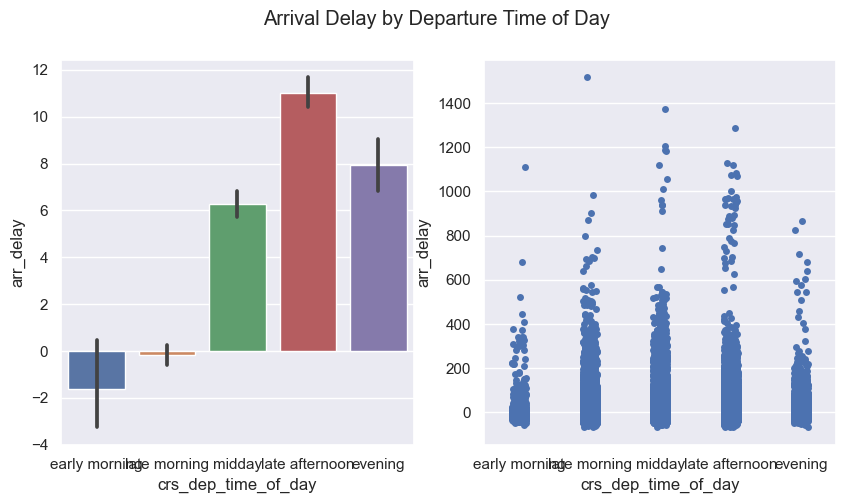

In [38]:
target_rel(df_flights, feature='crs_dep_time_of_day', feature_title='Departure Time of Day')

In [39]:
df_flights.loc[df_flights['crs_dep_time'].isna(), ['crs_dep_time']]

,crs_dep_time
9472,NaT
17287,NaT
22730,NaT
25155,NaT
26211,NaT
26772,NaT
39621,NaT
45944,NaT
46870,NaT
49001,NaT


In [40]:
df_flights.dropna(inplace=True)

In [41]:
df_flights.loc[df_flights['crs_dep_time'].isna(), ['crs_dep_time']]

,crs_dep_time


### Arrival Time of Day and Arr_Delay

In [42]:
# look at relationship between arrival time of day and arr_delay

df_flights['crs_arr_time'] = df_flights['crs_arr_time'].astype(int)

In [43]:
df_flights['crs_arr_time'] = pd.to_datetime(df_flights['crs_arr_time'], format = '%H%M', errors = 'coerce')
df_flights['crs_arr_time_hour'] = df_flights['crs_arr_time'].dt.hour

In [44]:
cut_labels_5 = ['early morning', 'late morning', 'midday', 'late afternoon', 'evening']
cut_bins = [1, 5, 10, 15, 20, 24]
df_flights['crs_arr_time_of_day'] = pd.cut(df_flights['crs_arr_time_hour'], bins=cut_bins, labels=cut_labels_5)

In [45]:
df_flights.head(20)

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,mean_arr_delay,median_arr_delay,season,day_of_week,is_weekend,is_holiday,crs_dep_time_hour,crs_dep_time_of_day,crs_arr_time_hour,crs_arr_time_of_day
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,19.0,late afternoon,23.0,evening
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,21.0,evening,15.0,midday
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,6.0,late morning,11.0,midday
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,7.0,late morning,8.0,late morning
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,17.0,late afternoon,18.0,late afternoon
5,2018-01-01,WN,WN,WN,1683,WN,N221WN,1683,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,21.0,evening,22.0,evening
6,2018-01-01,WN,WN,WN,6083,WN,N7857B,6083,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,13.0,midday,14.0,midday
7,2018-01-01,WN,WN,WN,495,WN,N7720F,495,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,11.0,midday,14.0,midday
8,2018-01-01,WN,WN,WN,5488,WN,N777QC,5488,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,21.0,evening,1.0,NaN
9,2018-01-01,WN,WN,WN,6078,WN,N489WN,6078,12889,LAS,...,2.297154,-8.0,Winter,Monday,False,True,19.0,late afternoon,22.0,evening


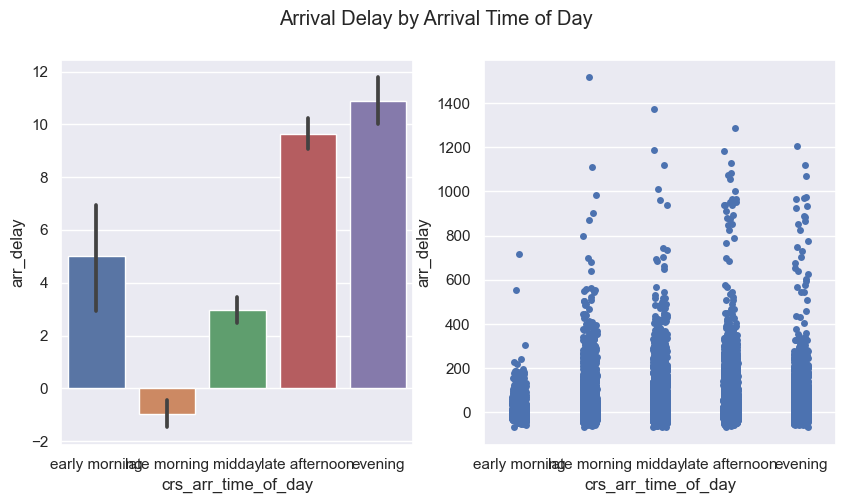

In [46]:
target_rel(df_flights, feature='crs_arr_time_of_day', feature_title='Arrival Time of Day')

In [47]:
len(df_flights.loc[df_flights['crs_arr_time'].isna(), ['crs_arr_time']])

264

In [48]:
df_flights.dropna(inplace=True)

In [49]:
df_flights.loc[df_flights['crs_arr_time'].isna(), ['crs_arr_time']]

,crs_arr_time


### Region and Arr_Delay

In [50]:
# look at relationship between region and arr_delay

In [51]:
new_origin = df_flights['origin_city_name'].str.split(",", n = 1, expand = True)
new_origin.head()

,0,1
0,Las Vegas,NV
1,Las Vegas,NV
2,Las Vegas,NV
3,Las Vegas,NV
4,Las Vegas,NV


In [52]:
new_dest = df_flights['dest_city_name'].str.split(",", n = 1, expand = True)
new_dest.head()

,0,1
0,Oklahoma City,OK
1,Omaha,NE
2,Omaha,NE
3,Ontario,CA
4,Ontario,CA


In [53]:
df_flights['origin_state'] = new_origin[1].str.strip()
df_flights['dest_state'] = new_dest[1].str.strip()
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,season,day_of_week,is_weekend,is_holiday,crs_dep_time_hour,crs_dep_time_of_day,crs_arr_time_hour,crs_arr_time_of_day,origin_state,dest_state
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,Winter,Monday,False,True,19.0,late afternoon,23.0,evening,NV,OK
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,Winter,Monday,False,True,21.0,evening,15.0,midday,NV,NE
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,Winter,Monday,False,True,6.0,late morning,11.0,midday,NV,NE
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,Winter,Monday,False,True,7.0,late morning,8.0,late morning,NV,CA
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,Winter,Monday,False,True,17.0,late afternoon,18.0,late afternoon,NV,CA


In [54]:
# Add a region feature that groups states into four regions
# Region Dictionary for States *includes DC and Puerto Rico

state_region = {
    'WA': 'West',
    'OR': 'West',
    'CA': 'West',
    'AK': 'West',
    'HI': 'West',
    'ID': 'West',
    'MT': 'West',
    'WY': 'West',
    'NV': 'West',
    'UT': 'West',
    'CO': 'West',
    'AZ': 'West',
    'NM': 'West',
    'ND': 'Midwest',
    'SD': 'Midwest',
    'MN': 'Midwest',
    'NE': 'Midwest',
    'KS': 'Midwest',
    'IA': 'Midwest',
    'MO': 'Midwest',
    'WI': 'Midwest',
    'IL': 'Midwest',
    'MI': 'Midwest',
    'IN': 'Midwest',
    'OH': 'Midwest',
    'VT': 'Northeast',
    'ME': 'Northeast',
    'NH': 'Northeast',
    'MA': 'Northeast',
    'NY': 'Northeast',
    'PA': 'Northeast',
    'RI': 'Northeast',
    'CT': 'Northeast',
    'NJ': 'Northeast',
    'DE': 'South',
    'MD': 'South',
    'WV': 'South',
    'DC': 'South',
    'VA': 'South',
    'KY': 'South',
    'NC': 'South',
    'OK': 'South',
    'TX': 'South',
    'AR': 'South',
    'LA': 'South',
    'MS': 'South',
    'AL': 'South',
    'TN': 'South',
    'SC': 'South',
    'GA': 'South',
    'FL': 'South',
    'PR': 'Other',
    'VI': 'Other',
    'TT': 'Other'
}
len(state_region)

54

In [55]:
df_flights["origin_region"] = df_flights["origin_state"].map(state_region)

In [56]:
df_flights["dest_region"] = df_flights["dest_state"].map(state_region)

In [57]:
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,is_weekend,is_holiday,crs_dep_time_hour,crs_dep_time_of_day,crs_arr_time_hour,crs_arr_time_of_day,origin_state,dest_state,origin_region,dest_region
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,False,True,19.0,late afternoon,23.0,evening,NV,OK,West,South
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,False,True,21.0,evening,15.0,midday,NV,NE,West,Midwest
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,False,True,6.0,late morning,11.0,midday,NV,NE,West,Midwest
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,False,True,7.0,late morning,8.0,late morning,NV,CA,West,West
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,False,True,17.0,late afternoon,18.0,late afternoon,NV,CA,West,West


In [58]:
df_flights['origin_region'].value_counts()

South        38075
West         28059
Midwest      18528
Northeast    13162
Other          539
Name: origin_region, dtype: int64

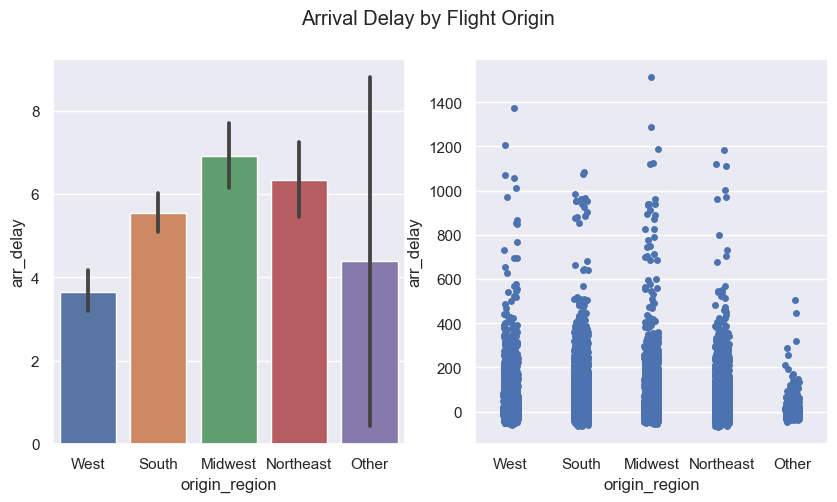

In [59]:
target_rel(df_flights, feature='origin_region', feature_title='Flight Origin')

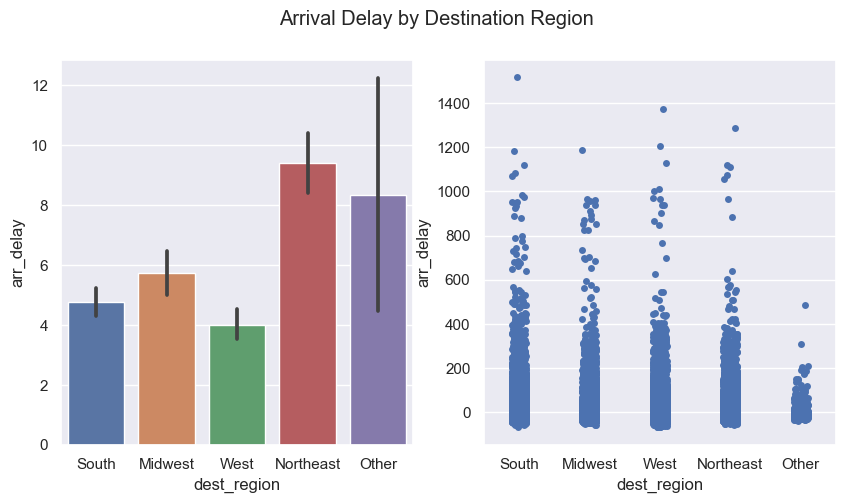

In [60]:
target_rel(df_flights, feature='dest_region', feature_title='Destination Region')

### Flight Type and Arr_Delay

In [61]:
# look at relationship between flight type and arr_delay

df_flights['haul'] = pd.cut(df_flights['distance'], bins = [0,800,2200,5000],labels=['short','medium','long'])
df_flights.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,is_holiday,crs_dep_time_hour,crs_dep_time_of_day,crs_arr_time_hour,crs_arr_time_of_day,origin_state,dest_state,origin_region,dest_region,haul
0,2018-01-01,WN,WN,WN,5431,WN,N291WN,5431,12889,LAS,...,True,19.0,late afternoon,23.0,evening,NV,OK,West,South,medium
1,2018-01-01,WN,WN,WN,989,WN,N287WN,989,12889,LAS,...,True,21.0,evening,15.0,midday,NV,NE,West,Midwest,medium
2,2018-01-01,WN,WN,WN,1664,WN,N751SW,1664,12889,LAS,...,True,6.0,late morning,11.0,midday,NV,NE,West,Midwest,medium
3,2018-01-01,WN,WN,WN,1106,WN,N704SW,1106,12889,LAS,...,True,7.0,late morning,8.0,late morning,NV,CA,West,West,short
4,2018-01-01,WN,WN,WN,1559,WN,N423WN,1559,12889,LAS,...,True,17.0,late afternoon,18.0,late afternoon,NV,CA,West,West,short


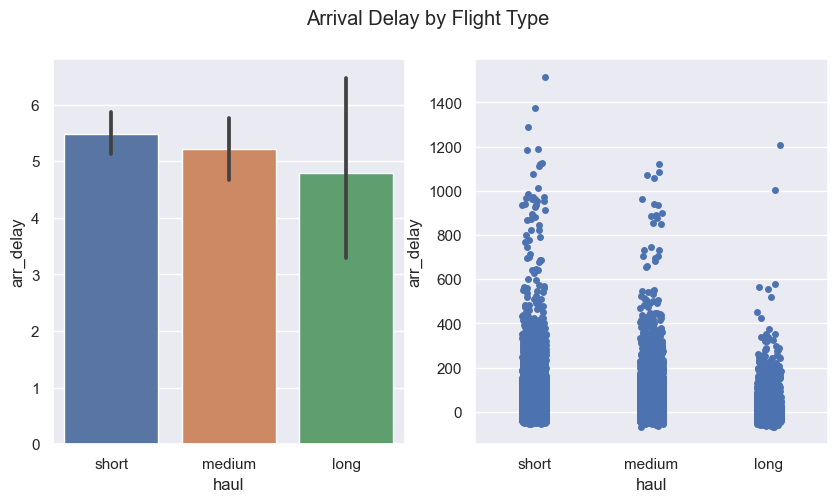

In [62]:
target_rel(df_flights, feature='haul', feature_title='Flight Type')

In [63]:
# make a pickle of the feature engineered data
import pickle

#Do Some Feature Engineering
feature_engineered_data = df_flights

#Dump it(save it in binary format)
with open(r'..\data\flight_data_engineered.pickle','wb') as flight_data_file:
     pickle.dump(feature_engineered_data, flight_data_file)